In [34]:
# Importing the necessary libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [35]:
# Getting the stock quote
df = pd.read_csv('/content/EICHERMOT.NS.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,3039.995117,3042.000000,2985.000000,2989.314941,2674.030518,198470
1,2018-01-02,2992.500000,2995.500000,2853.969971,2867.014893,2564.629883,847930
2,2018-01-03,2885.000000,2904.500000,2854.215088,2881.435059,2577.529053,470880
3,2018-01-04,2882.570068,2895.760010,2841.500000,2857.074951,2555.737793,494210
4,2018-01-05,2879.699951,2932.500000,2868.620117,2923.699951,2615.336182,527770
...,...,...,...,...,...,...,...
1231,2022-12-26,3115.000000,3228.649902,3088.199951,3161.250000,3161.250000,530294
1232,2022-12-27,3174.949951,3213.149902,3150.000000,3201.800049,3201.800049,422130
1233,2022-12-28,3188.149902,3233.600098,3175.600098,3211.550049,3211.550049,318724
1234,2022-12-29,3181.050049,3490.750000,3163.250000,3281.199951,3281.199951,881072


In [36]:
# Creating a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Converting the dataframe to a numpy array
dataset = data.values

Text(0, 0.5, 'Prices ($)')

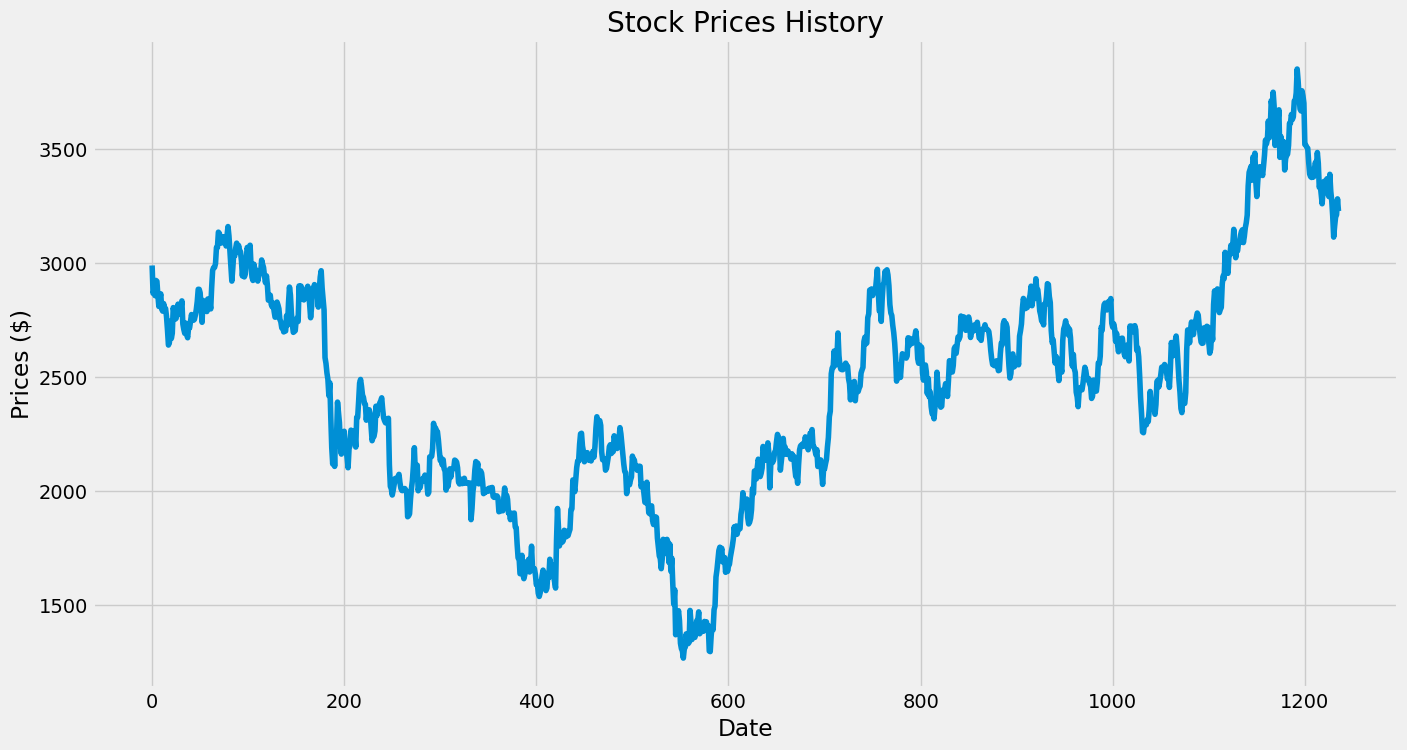

In [37]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [38]:
# Getting the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

In [39]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [40]:
# Creating the training data set
train_data = scaled_data[0:training_data_len, :]

In [41]:
# Splitting the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [42]:
# Converting the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [43]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [44]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
# Training the model
model.fit(x_train, y_train, batch_size=2, epochs=3)

Epoch 1/3
465/465 [==============================] - 27s 49ms/step - loss: 0.0042
Epoch 2/3
465/465 [==============================] - 22s 48ms/step - loss: 0.0013
Epoch 3/3
465/465 [==============================] - 22s 47ms/step - loss: 0.0013


In [46]:
# Creating the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Creating the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Converting the data to a numpy array
x_test = np.array(x_test)

# Reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [47]:
# Getting the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


8/8 [==============================] - 1s 17ms/step


In [48]:
# Getting the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE:', rmse)


RMSE: 21.353907037955466


In [49]:
# Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:].copy()

# Create a new column in the valid DataFrame for the predictions
valid['Predictions'] = predictions

# Use the .loc accessor to set the values for the new column
valid.loc[:, 'Predictions'] = predictions

In [50]:
predictions.shape

(247, 1)

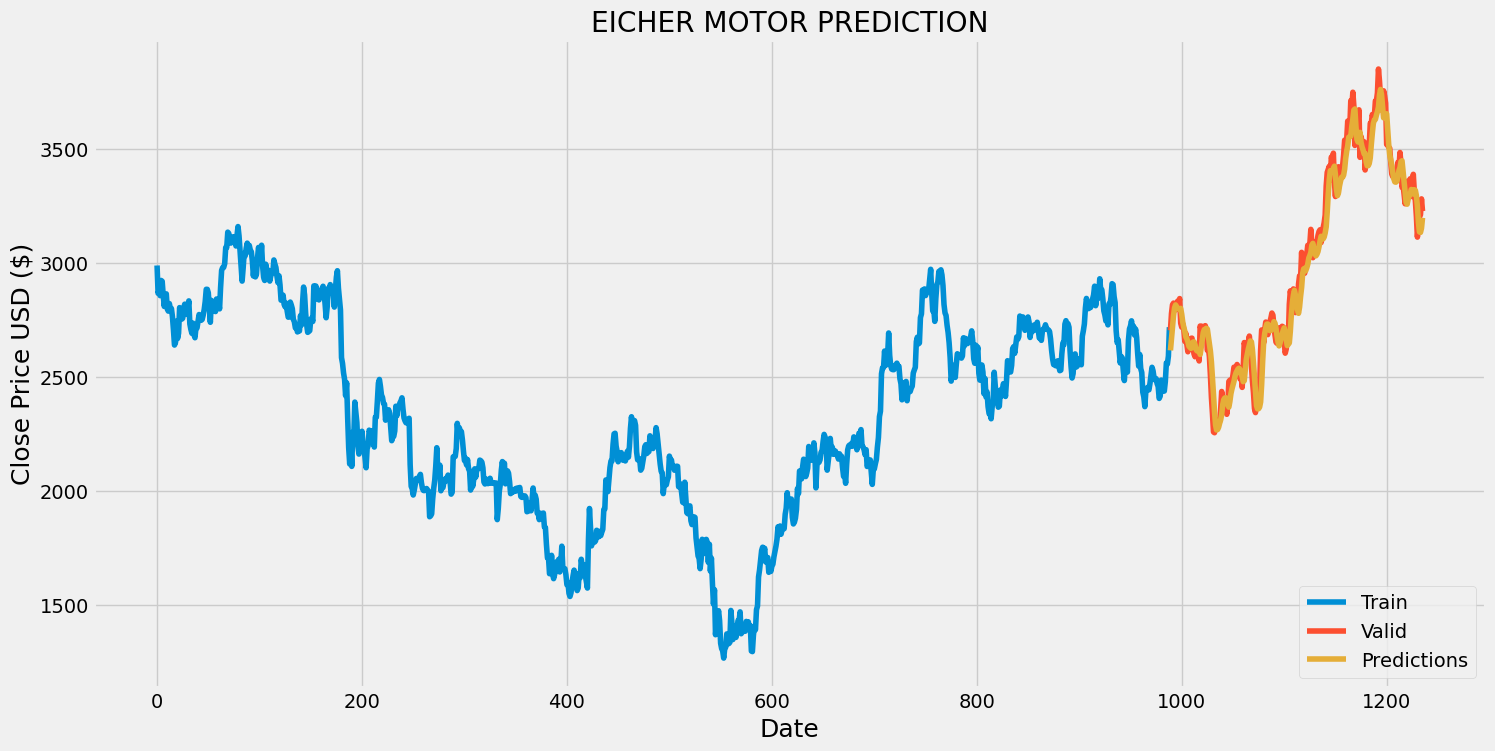

In [51]:
plt.figure(figsize=(16,8))
plt.title('EICHER MOTOR PREDICTION')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [52]:
# Predicting the stock prices for the next 365 days
Adani_power_quote = pd.read_csv('/content/EICHERMOT.NS.csv')
new_df = Adani_power_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print('Predicted price for the next day:', pred_price)


1/1 [==============================] - 0s 29ms/step
Predicted price for the next day: [[3223.035]]


In [53]:
forecast = []
forecast.append(pred_price)

for i in range(1, 365):
    last_60_days_scaled = scaler.transform(last_60_days[-60:].reshape(-1, 1))
    last_60_days = np.append(last_60_days[1:], pred_price)
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    forecast.append(pred_price)

1/1 [==============================] - 0s 39ms/step


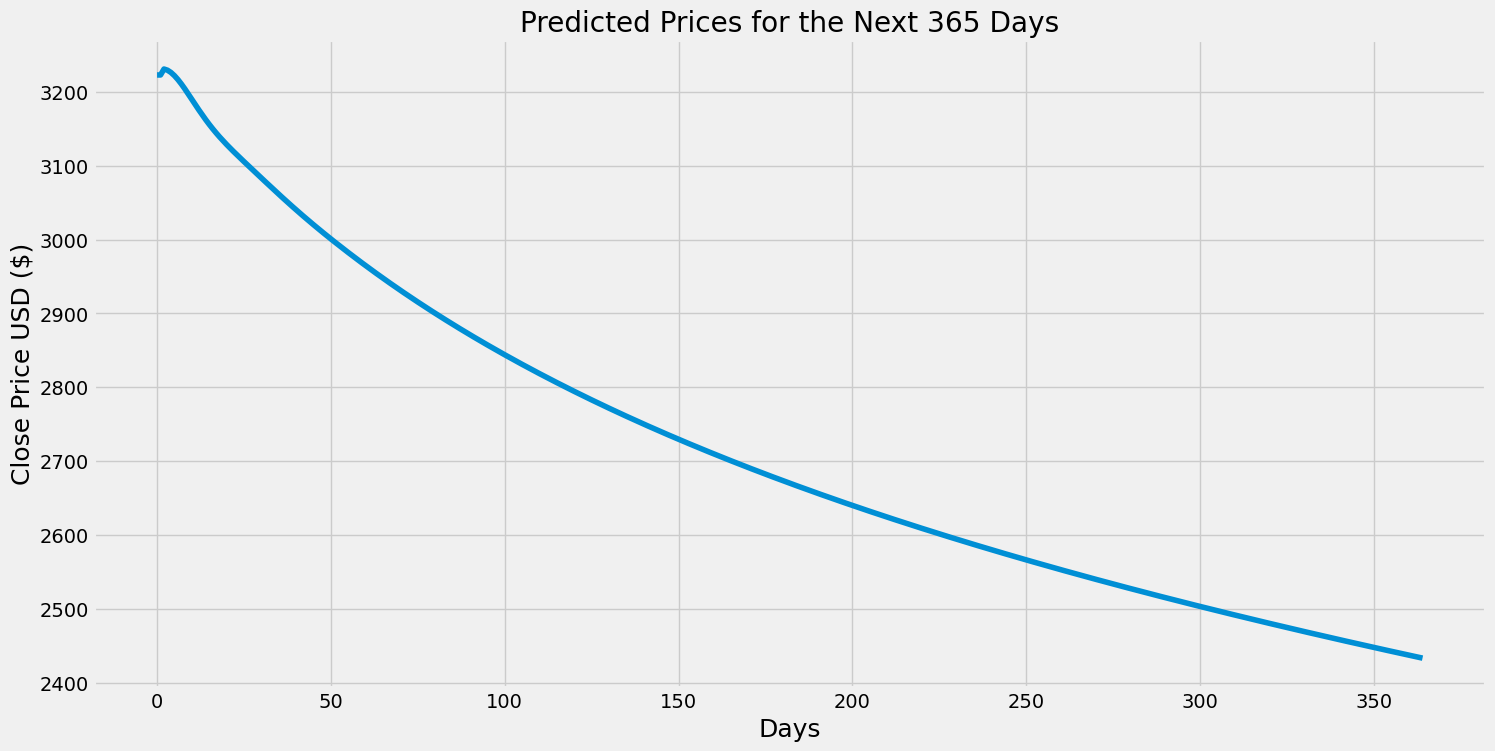

In [54]:
forecast = np.array(forecast).flatten()
plt.figure(figsize=(16,8))
plt.title('Predicted Prices for the Next 365 Days')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(forecast)
plt.show()

In [55]:
forecast

array([3223.035 , 3223.035 , 3231.0667, 3229.4878, 3226.4045, 3222.0835,
       3216.7837, 3210.7156, 3204.0945, 3197.1248, 3189.99  , 3182.846 ,
       3175.8142, 3168.9832, 3162.4114, 3156.131 , 3150.148 , 3144.454 ,
       3139.0261, 3133.8337, 3128.8406, 3124.0107, 3119.3086, 3114.7026,
       3110.1648, 3105.6733, 3101.211 , 3096.765 , 3092.3293, 3087.899 ,
       3083.4744, 3079.0566, 3074.6511, 3070.2603, 3065.89  , 3061.5452,
       3057.2307, 3052.9497, 3048.7063, 3044.5022, 3040.339 , 3036.2183,
       3032.1387, 3028.101 , 3024.1045, 3020.1472, 3016.2285, 3012.347 ,
       3008.5012, 3004.6887, 3000.9102, 2997.1633, 2993.4473, 2989.7612,
       2986.1047, 2982.477 , 2978.8772, 2975.3057, 2971.761 , 2968.2437,
       2964.7534, 2961.29  , 2957.8525, 2954.4412, 2951.0564, 2947.697 ,
       2944.3625, 2941.0535, 2937.7695, 2934.5093, 2931.274 , 2928.062 ,
       2924.8735, 2921.709 , 2918.5664, 2915.447 , 2912.3494, 2909.2737,
       2906.22  , 2903.187 , 2900.176 , 2897.1855, 